# **Decision Tree**

**This deciscion tree has taken the data from the gold data**

- Load libraries

In [1]:
# Decision Tree Model for Predicting Vaccine Probabilities with Categorical Handling

# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_auc_score, confusion_matrix, classification_report, roc_curve
from sklearn.multioutput import MultiOutputClassifier

- Load data

In [2]:
# Load the datasets
X_train_df = pd.read_csv('../data/gold/X_train_df.csv', index_col='respondent_id')
training_set_labels_df = pd.read_csv('../data/raw/training_set_labels.csv', index_col='respondent_id')
X_test_df = pd.read_csv('../data/gold/X_test_df.csv', index_col='respondent_id')
submission_format_df = pd.read_csv('../data/raw/submission_format.csv', index_col='respondent_id')


### **MODELING**

In [3]:
X_train, X_test, y_train, y_test = train_test_split(X_train_df, training_set_labels_df, test_size=0.2, random_state=42, stratify=training_set_labels_df)


In [4]:
# MultiOutputClassifier with Decision Tree
multi_output_clf = MultiOutputClassifier(DecisionTreeClassifier(random_state=42))

**The Cross Validation is commented because it has been already carried out. To avoid longer running times, the best hyperparameters obtained are already passed to the model**

In [5]:
# # Hyperparameter Grid for Decision Trees
# param_grid = {
#     'estimator__max_depth': [3, 5, 10, None],
#     'estimator__min_samples_split': [2, 5, 10],
#     'estimator__min_samples_leaf': [1, 2, 4]
# }

In [6]:
# # GridSearchCV for Hyperparameter Tuning
# grid_search = GridSearchCV(
#     estimator=multi_output_clf,
#     param_grid=param_grid,
#     cv=5,  # 5-fold cross-validation
#     scoring='roc_auc',  # Use ROC AUC as the scoring metric
#     n_jobs=-1  # Use all available cores
# )

In [7]:
# # Print Best Parameters and Score
# print("Best parameters:", grid_search.best_params_)
# print("Best cross-validation score (AUC):", grid_search.best_score_)

# Best parameters: {'estimator__max_depth': 5, 'estimator__min_samples_leaf': 4, 'estimator__min_samples_split': 2}
# Best cross-validation score (AUC): 0.8306425214386911

- Model with the best parameters obtained in the cross validation commented above

In [8]:
estimators = MultiOutputClassifier(
    estimator=DecisionTreeClassifier(
        max_depth=5, 
        min_samples_leaf=4,
        min_samples_split=2
    )
)

- Fit the models.

In [9]:
# Fit estimators after GridSearch
estimators.fit(X_train, y_train)

MultiOutputClassifier(estimator=DecisionTreeClassifier(max_depth=5,
                                                       min_samples_leaf=4))

- Predictions

In [10]:
# Best Estimator for Predictions
preds = estimators.predict_proba(X_test)

Dataframe with predictions (one column for each label prediction)

In [11]:
# Convert Predictions to DataFrame
y_preds = pd.DataFrame(
    {
        'h1n1_vaccine': preds[0][:, 1],
        'seasonal_vaccine': preds[1][:, 1],
    },
    index=y_test.index
)
print('y_preds.shape:', y_preds.shape)

y_preds.shape: (5342, 2)


### **RESULTS: ROC CURVE**

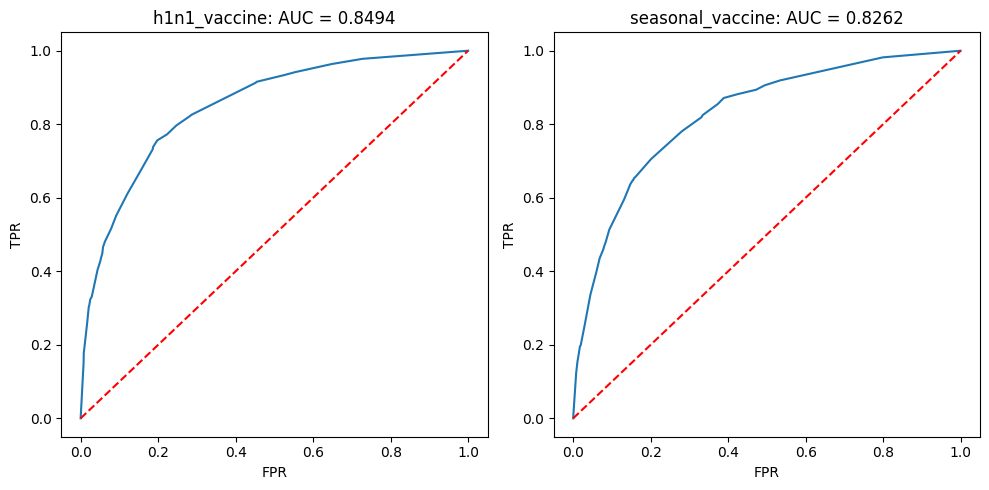

In [12]:
# ROC Curve Plotting
def plot_roc(y_true, y_score, label_name, ax):
    fpr, tpr, thresholds = roc_curve(y_true, y_score)
    ax.plot(fpr, tpr)
    ax.plot([0, 1], [0, 1], color='red', linestyle='--')
    ax.set_ylabel('TPR')
    ax.set_xlabel('FPR')
    ax.set_title(f"{label_name}: AUC = {roc_auc_score(y_true, y_score):.4f}")

fig, ax = plt.subplots(1, 2, figsize=(10, 5))

plot_roc(
    y_test['h1n1_vaccine'],
    y_preds['h1n1_vaccine'],
    'h1n1_vaccine',
    ax=ax[0]
)

plot_roc(
    y_test['seasonal_vaccine'],
    y_preds['seasonal_vaccine'],
    'seasonal_vaccine',
    ax=ax[1]
)

fig.tight_layout()

### **MAKE AND SAVE THE PREDICTIONS TO UPLOAD TO THE COMPETITION**

In [13]:
# Final Model Fitting on Full Training Data
estimators.fit(X_train_df, training_set_labels_df)
preds = estimators.predict_proba(X_test_df)

In [14]:
# Generate Final Predictions
y_preds = pd.DataFrame(
    {
        'h1n1_vaccine': preds[0][:, 1],
        'seasonal_vaccine': preds[1][:, 1],
    },
    index=X_test_df.index
)
print('y_preds.shape:', y_preds.shape)

y_preds.shape: (26708, 2)


In [15]:
# Save Predictions to CSV
y_preds.to_csv('../results/pred_decision_tree_output.csv', index=True)

**Conclusion**:
 - **We have obtained a better result (AUC SCORE) for the Decision Tree with data imputed from the gold data than the results obtained in the Decision Tree with its own imputation**